# Imports

In [7]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
import datetime
import matplotlib.pyplot as plt
from pprint import pprint
from utils import *
import math

# Load Data

In [3]:
sub_files = glob('/Users/camilla.strauss/Desktop/CUNY_Data/Data/*/*.xdf')

In [48]:
sub_number = 9
xdf_path = sub_files[sub_number]
sub_id = xdf_path.split('/')[6].split('-')[1]

mic_df = import_mic_data(xdf_path)
stim_df = import_stim_data(xdf_path)
et_df = import_et_data(xdf_path)
cam_df = import_video_data(xdf_path)
eeg_df = import_eeg_data(xdf_path)
ps_df = import_physio_data(xdf_path)

# Quick check

In [14]:
# quick check-- number of times et_df.lsl_time_stamp.diff() is over 1/120
sum([not math.isclose(x, 1/120, abs_tol=1e-2) for x in et_df.lsl_time_stamp.diff()]) - 1

1

In [ ]:
# indexes of where diff is not as expected: example with ps_df
srate = 1/(ps_df.lsl_time_stamp.diff().median())
ps_df['diff'] = ps_df.lsl_time_stamp.diff()

loss_index = np.where(ps_df['diff'] > 1/srate+.01)[0]
loss_index


array([435328, 454560, 578112])

In [ ]:
loss_amounts = ps_df['diff'][loss_index]
loss_amounts

435328    37.457195
454560    14.524082
578112    25.875676
Name: diff, dtype: float64

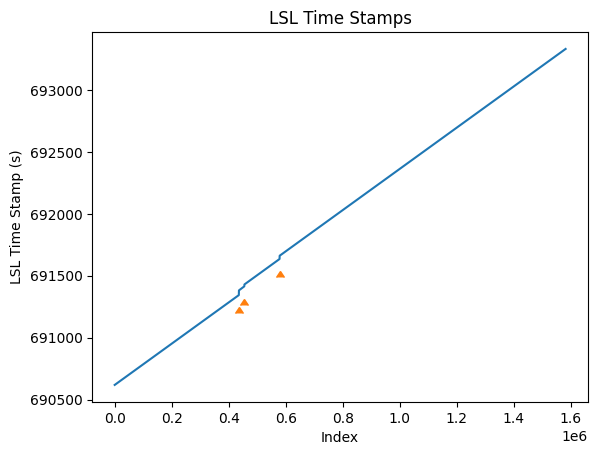

In [74]:
plt.plot(ps_df['lsl_time_stamp'])
plt.plot(loss_index, ps_df['lsl_time_stamp'][loss_index-1]-100, marker = 6, markersize = 6, linestyle='None')
plt.xlabel('Index')
plt.ylabel('LSL Time Stamp (s)')
plt.title('LSL Time Stamps')
plt.show()

# Percentage of missing data 

In [52]:
# df with percent loss (diff greater than median)
modalities = ['et', 'ps', 'mic', 'cam', 'eeg']
percent_list = []

timestamp = int(stim_df.loc[stim_df['event'] == 'psychopy_time_stamp', 'trigger'].iloc[0])
date_object = datetime.datetime.fromtimestamp(timestamp)
date_string = date_object.strftime("%Y-%m-%d")

for modality in modalities:
    df = globals()[modality+'_df']

    
    # median diff between lsl_time_stamp (with 1.05 margin) 
    df['diff'] = df['lsl_time_stamp'].diff()
    median1 = df['diff'].median() * 1.05
    # number of loss instances  
    loss_instances = (df['diff'] > median1).sum()
    if loss_instances != 0:
        # amount of data skipped: values for which diff>median 
        amt_data_lost = df.loc[df['diff'] > median1, 'diff'].values[0].sum()
        # total amount of data: last - first lsl_time_stamp
        amt_data_total = df['lsl_time_stamp'].values[-1] - df['lsl_time_stamp'].values[0]

        percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
    else:
        percent_lost = 0
    percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': sub_id, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss = pd.DataFrame(percent_list)
percent_data_loss.sort_values(by='percent_lost', inplace=True, ascending=False)
percent_data_loss


,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,42.149
3,9,2024-10-08,P5548165,cam,1,1.739
1,9,2024-10-08,P5548165,ps,3,1.379
2,9,2024-10-08,P5548165,mic,0,0.000
4,9,2024-10-08,P5548165,eeg,0,0.000


In [53]:
nonzero_loss = percent_data_loss[percent_data_loss['percent_lost'] != 0]
nonzero_loss

,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,42.149
3,9,2024-10-08,P5548165,cam,1,1.739
1,9,2024-10-08,P5548165,ps,3,1.379


In [55]:
# df with number of diff significantly BELOW median
short_diff_list = []

for modality in modalities:
    df = globals()[modality+'_df']
    
    # median diff between lsl_time_stamp (lower bound) (.99 for rounding)
    median2 = df['diff'].median() * .99
    # number of loss instances  
    short_instances = (df['diff'] < median2).sum()

    short_diff_list.append({'sub_num':sub_number, 'date': date_string, 'subject': sub_id, 'modality': modality, 'num_short': short_instances})
        
short_diff_df = pd.DataFrame(short_diff_list)
if sum(short_diff_df.num_short) != 0:
    print(short_diff_df)

# Amount of loss before offset_socialtask

In [58]:
# df with percent loss (diff greater than median), before social task offset
offset_social_timestamp = stim_df.loc[stim_df['event'] == 'Offset_SocialTask', 'lsl_time_stamp'].values[0]
social_percent_list = []

for modality in modalities:
    df = globals()[modality+'_df']
    social_df = df.loc[df.lsl_time_stamp <= offset_social_timestamp]

    # median diff between lsl_time_stamp (with 1.05 margin) 
    median1 = df['diff'].median() * 1.05

    # number of loss instances  
    loss_instances = (social_df['diff'] > median1).sum()
    percent_lost = 0
    amt_data_lost = 0

    # LSL loss starts and ends before offset_social
    if loss_instances != 0:
        # amount of data skipped: values for which diff>median 
        amt_data_lost = social_df.loc[social_df['diff'] > median1, 'diff'].values[0].sum()

    # offset social is between LSL loss onset + offset
    remaining_lost = offset_social_timestamp - social_df['lsl_time_stamp'].values[-1]
    if (remaining_lost) > 1:
        loss_instances +=1
        amt_data_lost = amt_data_lost + remaining_lost

    amt_data_total = offset_social_timestamp - social_df['lsl_time_stamp'].values[0]
    percent_lost = round(amt_data_lost/amt_data_total * 100, 3)

    social_percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': sub_id, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss_social = pd.DataFrame(social_percent_list)
percent_data_loss_social.sort_values(by='percent_lost', inplace=True, ascending=False)
percent_data_loss_social



,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,41.631
1,9,2024-10-08,P5548165,ps,3,1.434
2,9,2024-10-08,P5548165,mic,0,0.000
3,9,2024-10-08,P5548165,cam,0,0.000
4,9,2024-10-08,P5548165,eeg,0,0.000


In [ ]:
nonzero_loss_social = percent_data_loss_social[percent_data_loss_social['percent_lost'] != 0]
nonzero_loss_social

,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,41.631
1,9,2024-10-08,P5548165,ps,3,1.434


# Reported Metrics 

In [75]:
nonzero_loss
# possibly nonzero_loss_social or percent_data_loss

,sub_num,date,subject,modality,num_losses,percent_lost
0,9,2024-10-08,P5548165,et,1,42.149
3,9,2024-10-08,P5548165,cam,1,1.739
1,9,2024-10-08,P5548165,ps,3,1.379
